# 1. Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import itertools
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [6]:
from MFLUSolution import *

In [7]:
from selection_and_operators.mutation import swap_stages_slots_mutation, inversion_mutation, shuffle_mutation
from selection_and_operators.crossover import cycle_crossover, partially_matched_crossover, swap_time_slots_crossover
from selection_and_operators.selection import tournament_selection
from library.algorithm import *

In [8]:
from experiment import *

# 2. Genetic Algorithms

Baseline parameters:
- POP_SIZE = 50, 
- CROSSOVER_FUNCTION = cycle_crossover,
- MUTATION_FUNCTION = shuffle_mutation,
- NUMBER_OF_TESTS=30,
- MAX_GEN=100,
- S_RANKING_SELECTION=1.5,
- K_TOURNEMENT_SELECTION=5,
- SELECTION_ALGORITHM=tournament_selection,
- XO_PROB=0.9,
- MUT_PROB=0.4,
- MUT_MAX_WINDOW_SIZE=5, 
- ELITISM = True,
- VERBOSE = False

### 1st test - crossover and mutation operators:

Operators to test:

- Mutation: swap_slots_mutation, inversion_mutation, shuffle_mutation
- Crossover: cycle_crossover, partially_matched_crossover, swap_time_slots_crossover

In [9]:
MAX_GEN=100
NUMBER_OF_TESTS=30

In [10]:
grid_params = {
    "crossover": [
        {
            "function": partially_matched_crossover,
            "xo_prob": 0.9
        },
        {
            "function": swap_time_slots_crossover,
            "xo_prob": 0.9
        }
    ],
    "mutation": [
        {
            "function": swap_stages_slots_mutation,
            "mut_prob": 0.6
        },
        {
            "function": inversion_mutation,
            "mut_prob": 0.25
        },

        {
            "function": shuffle_mutation,
            "mut_prob": 0.25
        }


    ],
    "elitism": [True]
}

In [11]:
all_results_test1=[] # list to store the results for all the experiments
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["elitism"]))
fitness_dfs = {}

for crossover_cfg, mutation_cfg, elitism in grid:

    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]
    experiment_name = f"{mutation_function.__name__}{mut_prob}__{crossover_function.__name__}{xo_prob}__el_{elitism}"
    print(f"\n\nRunning experiment: {experiment_name}")
    
    result = run_experiment_ga(
        EXPERIMENT_NAME=experiment_name,
        MUTATION_FUNCTION=mutation_function,
        CROSSOVER_FUNCTION=crossover_function,
        MUT_PROB=mut_prob,
        XO_PROB=xo_prob,
        MAX_GEN=MAX_GEN,
        NUMBER_OF_TESTS=NUMBER_OF_TESTS
    )
    all_results_test1.append(result)
    fitness_dfs[experiment_name] = result['df']




Running experiment: swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True

Iteration 0 of the genetic algorithm

Final best individual in generation 1: 0.6828907767720013
Final best individual in generation 2: 0.6828907767720013
Final best individual in generation 3: 0.6828907767720013
Final best individual in generation 4: 0.7259586913093622
Final best individual in generation 5: 0.7259586913093622
Final best individual in generation 6: 0.7272606781922635
Final best individual in generation 7: 0.7376900063519356
Final best individual in generation 8: 0.7457771248187393
Final best individual in generation 9: 0.7513927671382032
Final best individual in generation 10: 0.7613731893377266
Final best individual in generation 11: 0.7676867259883419
Final best individual in generation 12: 0.7676867259883419
Final best individual in generation 13: 0.7761070177780526
Final best individual in generation 14: 0.7769610457844459
Final best individual in generation 15: 0.796331736

In [12]:
print(list(fitness_dfs.keys()))

['swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True', 'inversion_mutation0.25__partially_matched_crossover0.9__el_True', 'shuffle_mutation0.25__partially_matched_crossover0.9__el_True', 'swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True', 'inversion_mutation0.25__swap_time_slots_crossover0.9__el_True', 'shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True']


In [13]:
fitness_dfs_ga_el_true=deepcopy(fitness_dfs)

In [14]:
def plot_avg_median_fit_per_generation(results_dict, error_bar=False):

    colors = [
        '#1f77b4', '#2ca02c', '#ff7f0e',
        '#9467bd', '#8c564b', '#17becf',
        '#e377c2', '#7f7f7f', '#bcbd22',
        '#aec7e8', '#98df8a', '#ffbb78'
    ]

    experiments = list(results_dict.keys())
    num_experiments = len(experiments)

    # Determinar o número máximo de gerações a partir dos dados
    any_df = list(results_dict.values())[0]
    MAX_GEN = any_df.shape[1] - 1  # última coluna = última geração (0-based)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for i, (exp_name, df) in enumerate(results_dict.items()):
        color = colors[i % len(colors)]
        label = f"{i+1}: {exp_name}"

        df_t = df.T

        avg = df_t.mean(axis=1)
        std = df_t.std(axis=1)
        med = df_t.median(axis=1)
        generations = df_t.index

        ax1.plot(generations, avg, label=label, color=color, linewidth=2)        
        if error_bar:
            ax1.errorbar(generations, avg, yerr=std, fmt='o', capsize=4, markersize=4,
             linestyle='-', color=color, linewidth=2)
        else:
            ax1.fill_between(generations, avg - std, avg + std, color=color, alpha=0.2)
        ax2.plot(generations, med, label=label, color=color, linewidth=2)
        for ax, title in zip((ax1, ax2), ("Average Fitness per Generation", "Median Fitness per Generation")):
            ax.set_title(title, fontsize=13, weight='bold')
            ax.set_xlabel("Generation")
            ax.set_xticks(list(range(0, MAX_GEN, 20)) + [MAX_GEN])  # Ensure MAX_GEN is included
            ax.set_xlim(0, MAX_GEN + 2)  # Add a little extra padding
            ax.grid(True, linestyle='--', alpha=0.5)

    ax1.set_ylabel("Fitness")

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.18), ncol=2, fontsize=8, frameon=False)

    plt.tight_layout()
    plt.show()

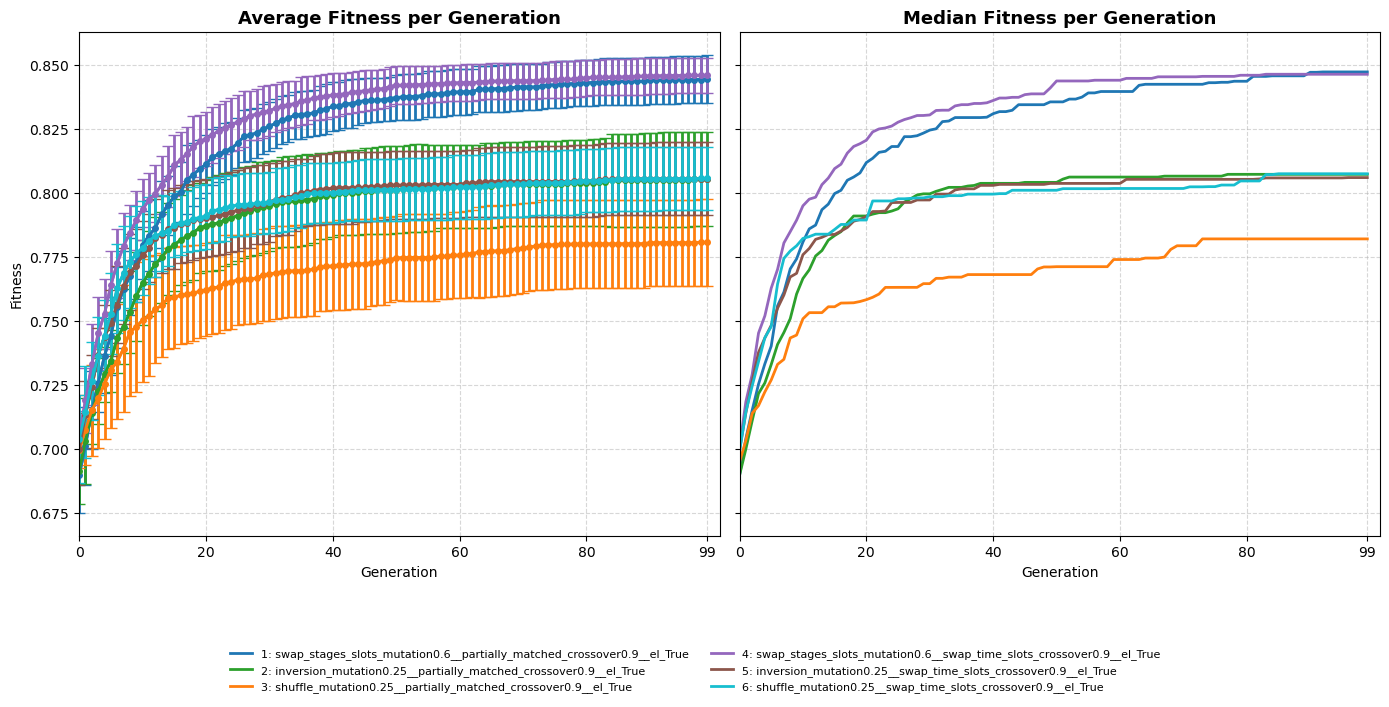

In [15]:
plot_avg_median_fit_per_generation(fitness_dfs_ga_el_true, error_bar=True)

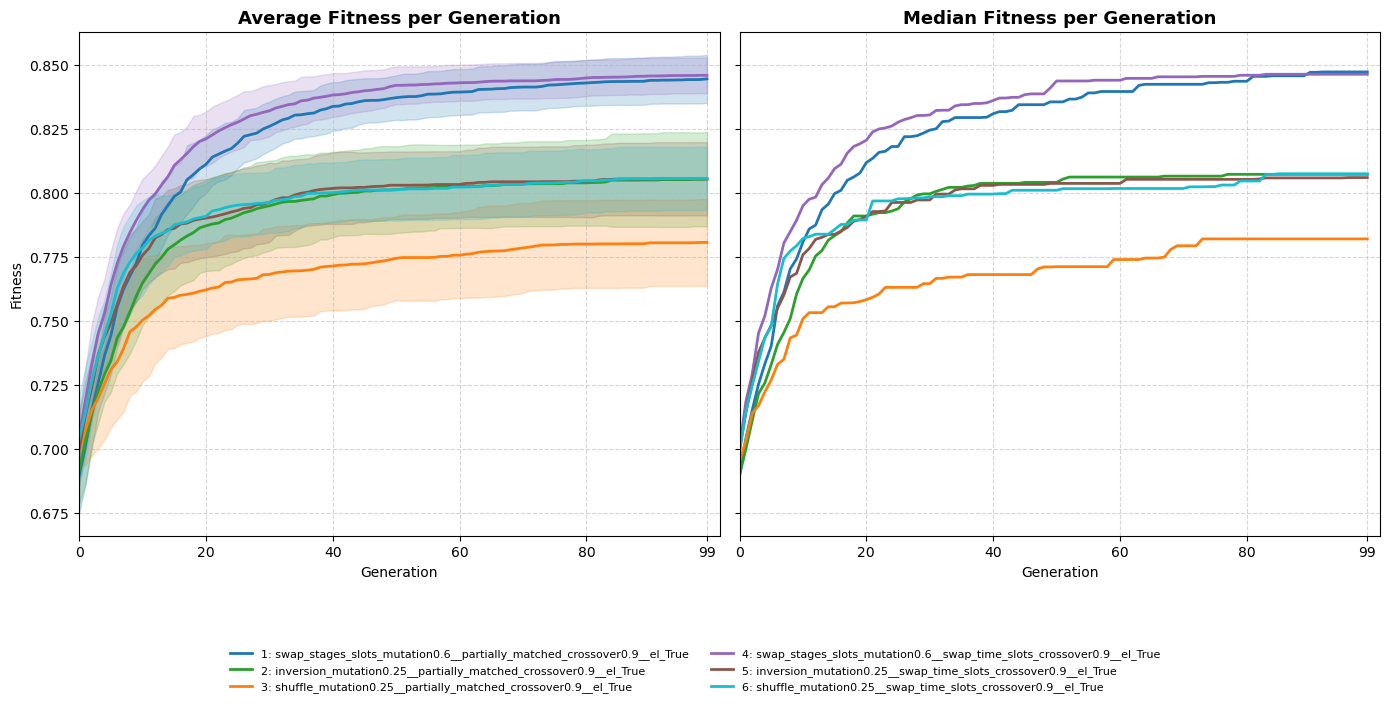

In [16]:
plot_avg_median_fit_per_generation(fitness_dfs_ga_el_true, error_bar=False)

In [17]:
def boxplots_final_fitness(results_input, legend=True, box_color="#4C72B0"):
    operator_names = []
    final_fitness_by_experiment = []

    # Validate input
    if isinstance(results_input, dict):
        for name, df in results_input.items():
            df_t = df if df.shape[0] > 1 else df.T
            final_fitness = df_t.iloc[:, -1].values
            final_fitness_by_experiment.append(final_fitness)
            operator_names.append(name)
    else:
        raise ValueError("Input must be a dict of DataFrames with final fitness values.")

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    positions = np.arange(1, len(operator_names) + 1)

    box = ax.boxplot(
        final_fitness_by_experiment,
        patch_artist=True,
        positions=positions,
        medianprops=dict(color='black'),
        whiskerprops=dict(color='gray'),
        capprops=dict(color='gray'),
        boxprops=dict(facecolor=box_color, color=box_color, alpha=0.8),
        flierprops=dict(marker='o', color='gray', alpha=0.5)
    )

    # Axes styling
    ax.set_xticks(positions)
    ax.set_xticklabels([str(i) for i in positions], fontsize=11)
    ax.set_xlabel("Experiment number", fontsize=13)
    ax.set_ylabel("Final Fitness", fontsize=13)
    ax.set_title("Final Fitness Distribution per Operator Combination", fontsize=15, weight='bold')

    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    legend_handles = [
        plt.Line2D([], [], linestyle='None', marker=None, color='none', label=f"{i}: {name}")
        for i, name in enumerate(operator_names, start=1)
    ]

    ax.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        fontsize=10,
        ncol=2,
        frameon=False
    )

    plt.tight_layout()
    plt.show()


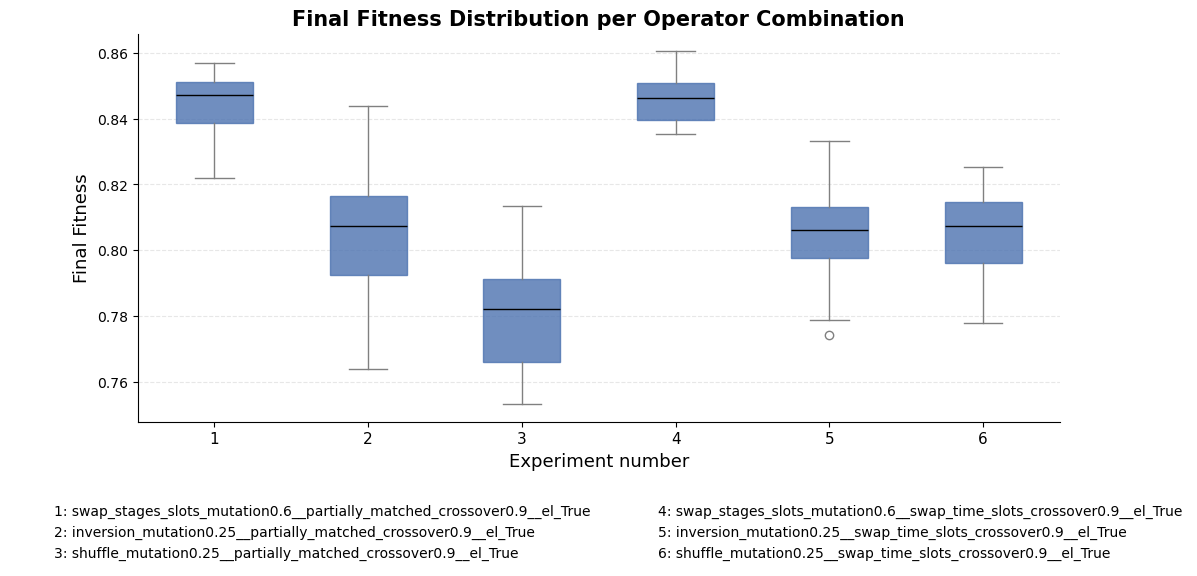

In [18]:
boxplots_final_fitness(fitness_dfs_ga_el_true)

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_std_error(fitness_dfs, legend=True, marker_color="tab:blue"):
    final_means = []
    final_stds = []
    operator_names = []

    for name, df in fitness_dfs.items():
        df_t = df if df.shape[0] > 1 else df.T
        final_gen_values = df_t.iloc[:, -1].values

        final_means.append(np.mean(final_gen_values))
        final_stds.append(np.std(final_gen_values, ddof=1))
        operator_names.append(name)

    x_pos = list(range(1, len(operator_names) + 1))

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.errorbar(
        x_pos,
        final_means,
        yerr=final_stds,
        fmt='o',
        capsize=5,
        markersize=6,
        linestyle='None',
        color=marker_color,
        linewidth=2
    )

    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(i) for i in x_pos], rotation=0, fontsize=10)
    ax.set_ylabel("Fitness", fontsize=12)
    ax.set_xlabel("Experiment number", fontsize=12)
    ax.set_title("Final Generation Fitness: Mean ± Std Dev", fontsize=14, weight='bold')
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    legend_handles = [
        plt.Line2D([], [], linestyle='None', marker=None, color='none', label=f"{i}: {name}")
        for i, name in enumerate(operator_names, start=1)
    ]

    plt.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fontsize=9,
        ncol=2,              
        frameon=False
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Ensure space for legend
    plt.show()


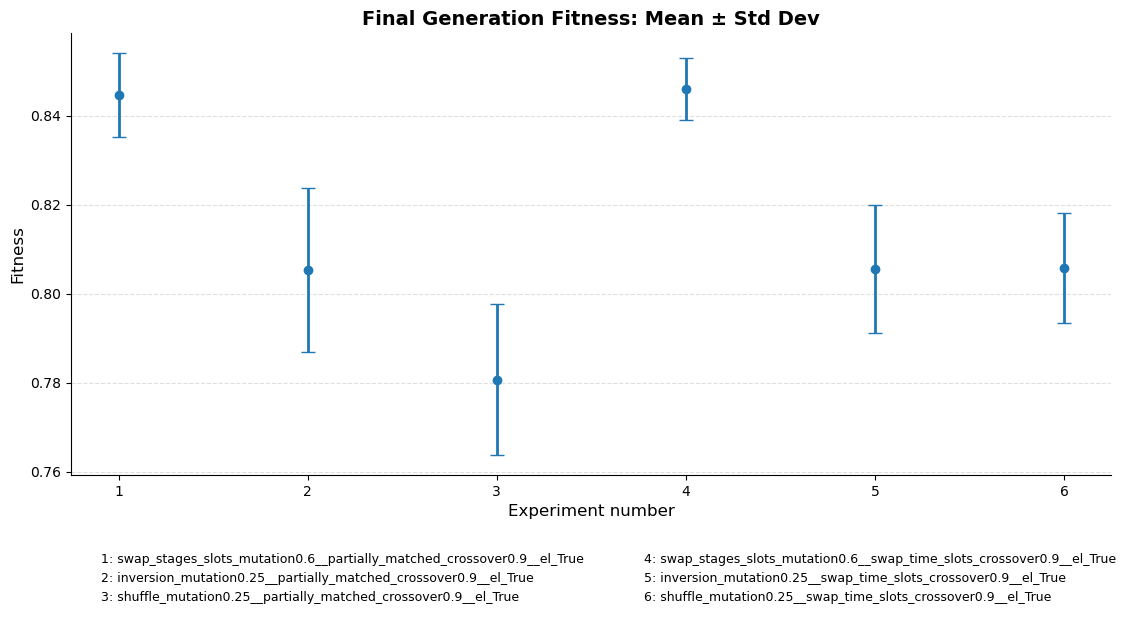

In [20]:
plot_mean_std_error(fitness_dfs_ga_el_true)

In [21]:
def avg_elapsed_time_table(all_results):
    pd.set_option('display.max_colwidth', None)
    data = []
    for result in all_results:
        data.append({
            "Experience Name": result['name'],
            "Elapsed Time Avg": result['avg_elapsed_time']
        })
    avg_elapsed_time = pd.DataFrame(data)
    avg_elapsed_time.index = range(1, len(all_results)+1)
    return avg_elapsed_time

In [22]:
avg_elapsed_time_table(all_results=all_results_test1)

Experience Name  \
1  swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True   
2         inversion_mutation0.25__partially_matched_crossover0.9__el_True   
3           shuffle_mutation0.25__partially_matched_crossover0.9__el_True   
4    swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True   
5           inversion_mutation0.25__swap_time_slots_crossover0.9__el_True   
6             shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True   

   Elapsed Time Avg  
1         55.396368  
2         53.216690  
3         53.705165  
4         53.907018  
5         75.031230  
6         55.771556

In [23]:
def compute_wilcoxon_pvalues(fitness_dfs):
    # Extract last generation fitness values
    fitness_last_gen = {
        name: df.T.iloc[:, -1].values if df.shape[0] == 1 else df.iloc[:, -1].values
        for name, df in fitness_dfs.items()
    }

    # Prepare pairwise comparisons
    names = list(fitness_last_gen.keys())
    p_values_table = pd.DataFrame(np.nan, index=names, columns=names)

    for i, j in itertools.combinations(range(len(names)), 2):
        stat, p = wilcoxon(fitness_last_gen[names[i]], fitness_last_gen[names[j]])
        p_values_table.loc[names[i], names[j]] = p
        p_values_table.loc[names[j], names[i]] = p

    return p_values_table.round(3)

In [24]:
compute_wilcoxon_pvalues(fitness_dfs_ga_el_true)

swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True  \
swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True                                                                     NaN   
inversion_mutation0.25__partially_matched_crossover0.9__el_True                                                                          0.000   
shuffle_mutation0.25__partially_matched_crossover0.9__el_True                                                                            0.000   
swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True                                                                     0.715   
inversion_mutation0.25__swap_time_slots_crossover0.9__el_True                                                                            0.000   
shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True                                                                              0.000   

                                                                        inversion_mutation0.25__partially_matched_crossover0.9__el_True  \
swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True                                                            0.000   
inversion_mutation0.25__partially_matched_crossover0.9__el_True                                                                     NaN   
shuffle_mutation0.25__partially_matched_crossover0.9__el_True                                                                     0.000   
swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True                                                              0.000   
inversion_mutation0.25__swap_time_slots_crossover0.9__el_True                                                                     0.968   
shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True                                                                       0.855   

                                                                        shuffle_mutation0.25__partially_matched_crossover0.9__el_True  \
swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True                                                            0.0   
inversion_mutation0.25__partially_matched_crossover0.9__el_True                                                                   0.0   
shuffle_mutation0.25__partially_matched_crossover0.9__el_True                                                                     NaN   
swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True                                                              0.0   
inversion_mutation0.25__swap_time_slots_crossover0.9__el_True                                                                     0.0   
shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True                                                                       0.0   

                                                                        swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True  \
swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True                                                                 0.715   
inversion_mutation0.25__partially_matched_crossover0.9__el_True                                                                        0.000   
shuffle_mutation0.25__partially_matched_crossover0.9__el_True                                                                          0.000   
swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True                                                                     NaN   
inversion_mutation0.25__swap_time_slots_crossover0.9__el_True                                                                          0.000   
shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True                                                                            0.000   

                                                                        inversion_mutation0.25__swap_time_

In [25]:
grid_params = {
    "crossover": [
        {
            "function": partially_matched_crossover,
            "xo_prob": 0.9
        },
        {
            "function": swap_time_slots_crossover,
            "xo_prob": 0.9
        }
    ],
    "mutation": [
        {
            "function": swap_stages_slots_mutation,
            "mut_prob": 0.6
        },
        {
            "function": inversion_mutation,
            "mut_prob": 0.25
        },

        {
            "function": shuffle_mutation,
            "mut_prob": 0.25
        }


    ],
    "elitism": [False]
}

In [26]:
all_results_test2=[] # list to store the results for all the experiments
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["elitism"]))

for crossover_cfg, mutation_cfg, elitism in grid:

    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]
    experiment_name = f"{mutation_function.__name__}{mut_prob}__{crossover_function.__name__}{xo_prob}__{elitism}"
    print(f"\n\nRunning experiment: {experiment_name}")
    
    result = run_experiment_ga(
        EXPERIMENT_NAME=experiment_name,
        MUTATION_FUNCTION=mutation_function,
        CROSSOVER_FUNCTION=crossover_function,
        MUT_PROB=mut_prob,
        XO_PROB=xo_prob,
        MAX_GEN=MAX_GEN,
        NUMBER_OF_TESTS=NUMBER_OF_TESTS
    )
    all_results_test2.append(result)
    fitness_dfs[experiment_name] = result['df']




Running experiment: swap_stages_slots_mutation0.6__partially_matched_crossover0.9__False

Iteration 0 of the genetic algorithm

Final best individual in generation 1: 0.7020251778872467
Final best individual in generation 2: 0.7020251778872467
Final best individual in generation 3: 0.7020251778872467
Final best individual in generation 4: 0.716427873831525
Final best individual in generation 5: 0.7397998223679716
Final best individual in generation 6: 0.7397998223679716
Final best individual in generation 7: 0.7568729930996788
Final best individual in generation 8: 0.7568729930996788
Final best individual in generation 9: 0.7620994739359158
Final best individual in generation 10: 0.7701714832274372
Final best individual in generation 11: 0.7759786841565894
Final best individual in generation 12: 0.7864316458290633
Final best individual in generation 13: 0.7890448862471816
Final best individual in generation 14: 0.791077406572385
Final best individual in generation 15: 0.7910774065723

In [27]:
print(list(fitness_dfs.keys()))

['swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True', 'inversion_mutation0.25__partially_matched_crossover0.9__el_True', 'shuffle_mutation0.25__partially_matched_crossover0.9__el_True', 'swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__el_True', 'inversion_mutation0.25__swap_time_slots_crossover0.9__el_True', 'shuffle_mutation0.25__swap_time_slots_crossover0.9__el_True', 'swap_stages_slots_mutation0.6__partially_matched_crossover0.9__False', 'inversion_mutation0.25__partially_matched_crossover0.9__False', 'shuffle_mutation0.25__partially_matched_crossover0.9__False', 'swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__False', 'inversion_mutation0.25__swap_time_slots_crossover0.9__False', 'shuffle_mutation0.25__swap_time_slots_crossover0.9__False']


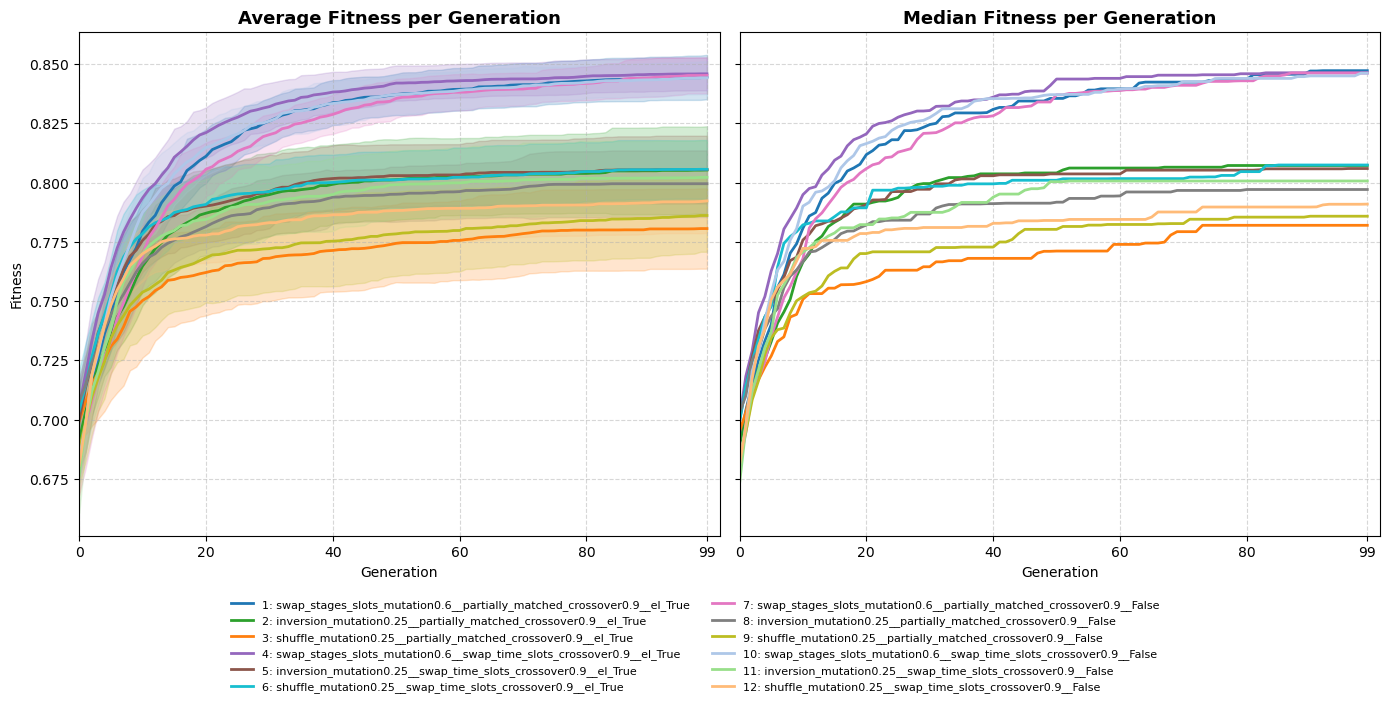

In [28]:
plot_avg_median_fit_per_generation(fitness_dfs)

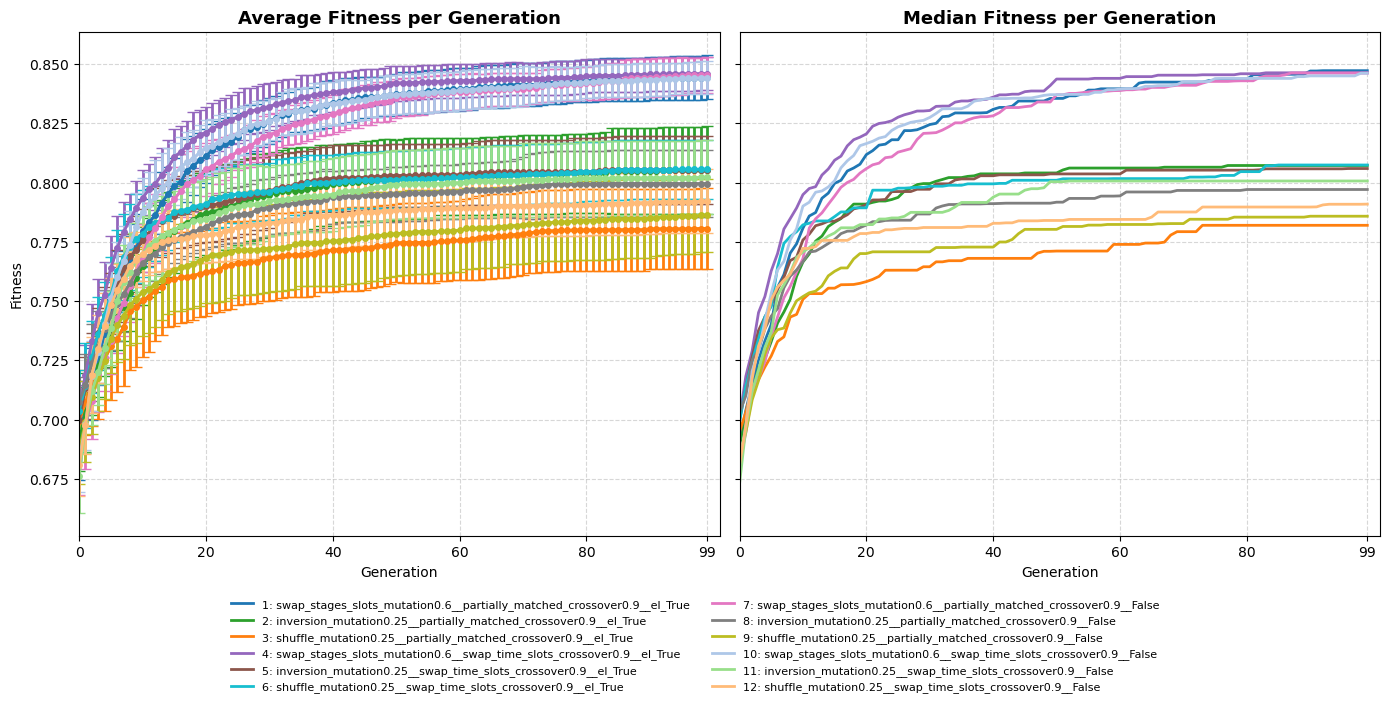

In [29]:
plot_avg_median_fit_per_generation(fitness_dfs, error_bar=True)

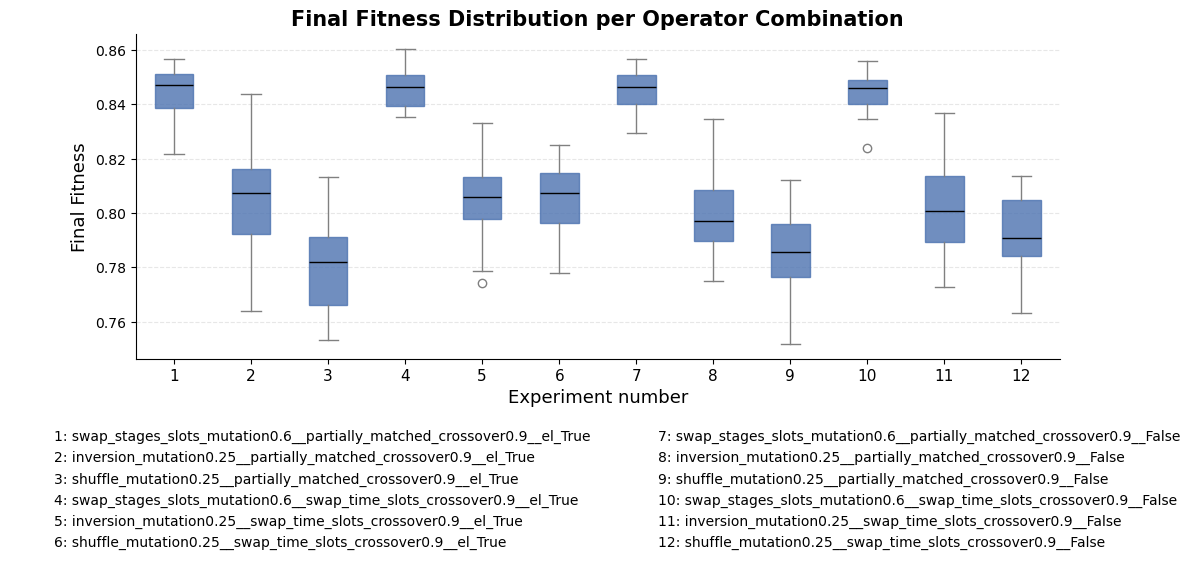

In [30]:
boxplots_final_fitness(fitness_dfs)

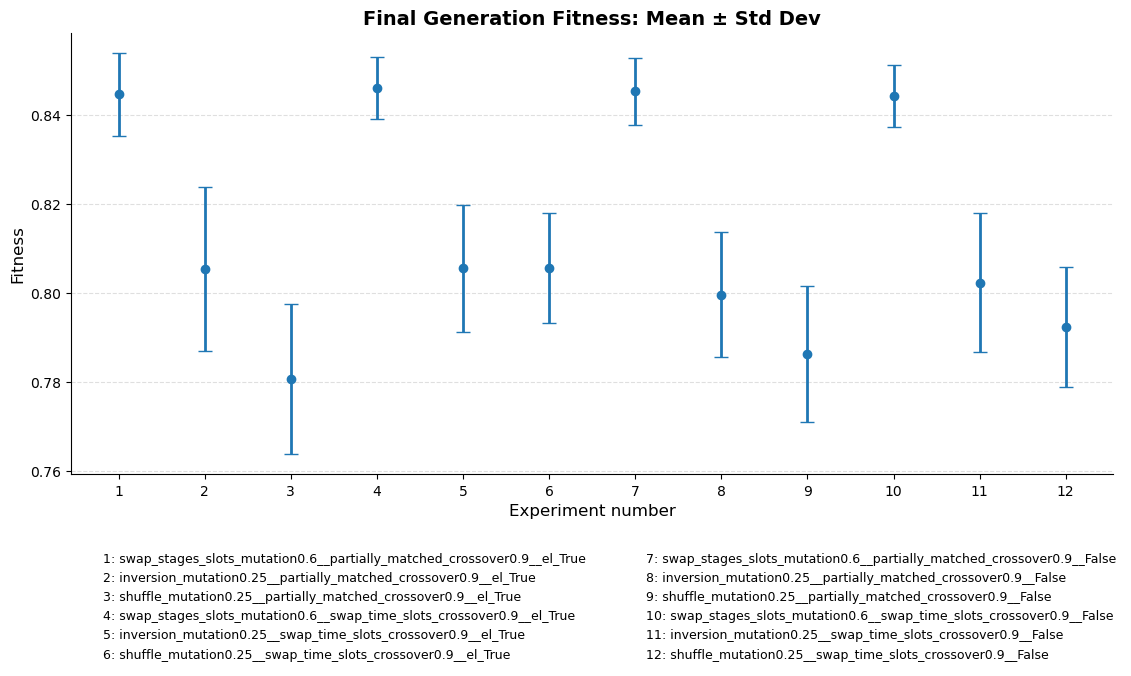

In [31]:
plot_mean_std_error(fitness_dfs)

In [32]:
avg_elapsed_time_table(all_results=all_results_test2)

Experience Name  \
1  swap_stages_slots_mutation0.6__partially_matched_crossover0.9__False   
2         inversion_mutation0.25__partially_matched_crossover0.9__False   
3           shuffle_mutation0.25__partially_matched_crossover0.9__False   
4    swap_stages_slots_mutation0.6__swap_time_slots_crossover0.9__False   
5           inversion_mutation0.25__swap_time_slots_crossover0.9__False   
6             shuffle_mutation0.25__swap_time_slots_crossover0.9__False   

   Elapsed Time Avg  
1         53.087739  
2         54.229718  
3         53.675617  
4         54.219074  
5         53.822068  
6         53.926380

### Test crossover and mutation probabilities

In [33]:
# mutation_probabilities=[random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)]
# crossover_probabilities =[random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)]
# mut_funct=
# xo_funct=

In [34]:
# all_results_test2=[]
# for mut in mutation_probabilities:
#     for xo in crossover_probabilities:
#         experiment_name = f"mutation_prob:{mut}__crossover_prob{xo}"
#         print(f"Running experiment: {experiment_name}")
        
#         result = run_experiment_ga(
#             EXPERIMENT_NAME=experiment_name,
#             MUT_PORB=mut,
#             XO_PROB=xo,
#             MUTATION_FUNCTION=mut_funct,
#             CROSSOVER_FUNCTION=xo_funct,
#             MAX_GEN=40,
#             NUMBER_OF_TESTS=2
#         )

#         all_results_test2.append(result)

In [35]:
# plot_avg_median_fit_per_generation(all_results=all_results_test2)

In [36]:
# boxplots_final_fitness(all_results=all_results_test2)

In [37]:
# plot_mean_std_error(all_results=all_results_test2)

In [38]:
# avg_elapsed_time_table(all_results=all_results_test2)

# 3. Hill Climbing

In [39]:
MAX_ITER=100
NUMBER_OF_TESTS=30

In [40]:
result_hc=run_experiment_hc(
EXPERIMENT_NAME = f"hc",
NUMBER_OF_TESTS=NUMBER_OF_TESTS,
MAX_GEN=MAX_ITER)        


Iteration 0 of the HC algorithm


Iteration 1 of the HC algorithm


Iteration 2 of the HC algorithm


Iteration 3 of the HC algorithm


Iteration 4 of the HC algorithm


Iteration 5 of the HC algorithm


Iteration 6 of the HC algorithm


Iteration 7 of the HC algorithm


Iteration 8 of the HC algorithm


Iteration 9 of the HC algorithm


Iteration 10 of the HC algorithm


Iteration 11 of the HC algorithm


Iteration 12 of the HC algorithm


Iteration 13 of the HC algorithm


Iteration 14 of the HC algorithm


Iteration 15 of the HC algorithm


Iteration 16 of the HC algorithm


Iteration 17 of the HC algorithm


Iteration 18 of the HC algorithm


Iteration 19 of the HC algorithm


Iteration 20 of the HC algorithm


Iteration 21 of the HC algorithm


Iteration 22 of the HC algorithm


Iteration 23 of the HC algorithm


Iteration 24 of the HC algorithm


Iteration 25 of the HC algorithm


Iteration 26 of the HC algorithm


Iteration 27 of the HC algorithm


Iteration 28 of the HC algori

# 4. Simulated Annealing

In [41]:
MAX_ITER=100
NUMBER_OF_TESTS=30
C=[1.5, 2.5]
L=[10, 25]
H=[5, 20]

In [42]:
all_results_sa=[]
fitness_dfs_sa = {}

for c in C:
    for l in L:
        for h in H:
            experiment_name=f"sa__C_{c}__L_{l}__H_{h}"
            print(f"\n\nRunning experiment: {experiment_name}")
            result=run_experiment_sa(
            EXPERIMENT_NAME = experiment_name,
            NUMBER_OF_TESTS=NUMBER_OF_TESTS,
            MAX_GEN=MAX_ITER,
            C=c,
            L=l,
            H=h,
            VERBOSE=False)
            all_results_sa.append(result)
            fitness_dfs_sa[experiment_name]=result['df']



Running experiment: sa__C_1.5__L_10__H_5

Iteration 0 of the SA algorithm


Iteration 1 of the SA algorithm


Iteration 2 of the SA algorithm


Iteration 3 of the SA algorithm


Iteration 4 of the SA algorithm


Iteration 5 of the SA algorithm


Iteration 6 of the SA algorithm


Iteration 7 of the SA algorithm


Iteration 8 of the SA algorithm


Iteration 9 of the SA algorithm


Iteration 10 of the SA algorithm


Iteration 11 of the SA algorithm


Iteration 12 of the SA algorithm


Iteration 13 of the SA algorithm


Iteration 14 of the SA algorithm


Iteration 15 of the SA algorithm


Iteration 16 of the SA algorithm


Iteration 17 of the SA algorithm


Iteration 18 of the SA algorithm


Iteration 19 of the SA algorithm


Iteration 20 of the SA algorithm


Iteration 21 of the SA algorithm


Iteration 22 of the SA algorithm


Iteration 23 of the SA algorithm


Iteration 24 of the SA algorithm


Iteration 25 of the SA algorithm


Iteration 26 of the SA algorithm


Iteration 27 of the S

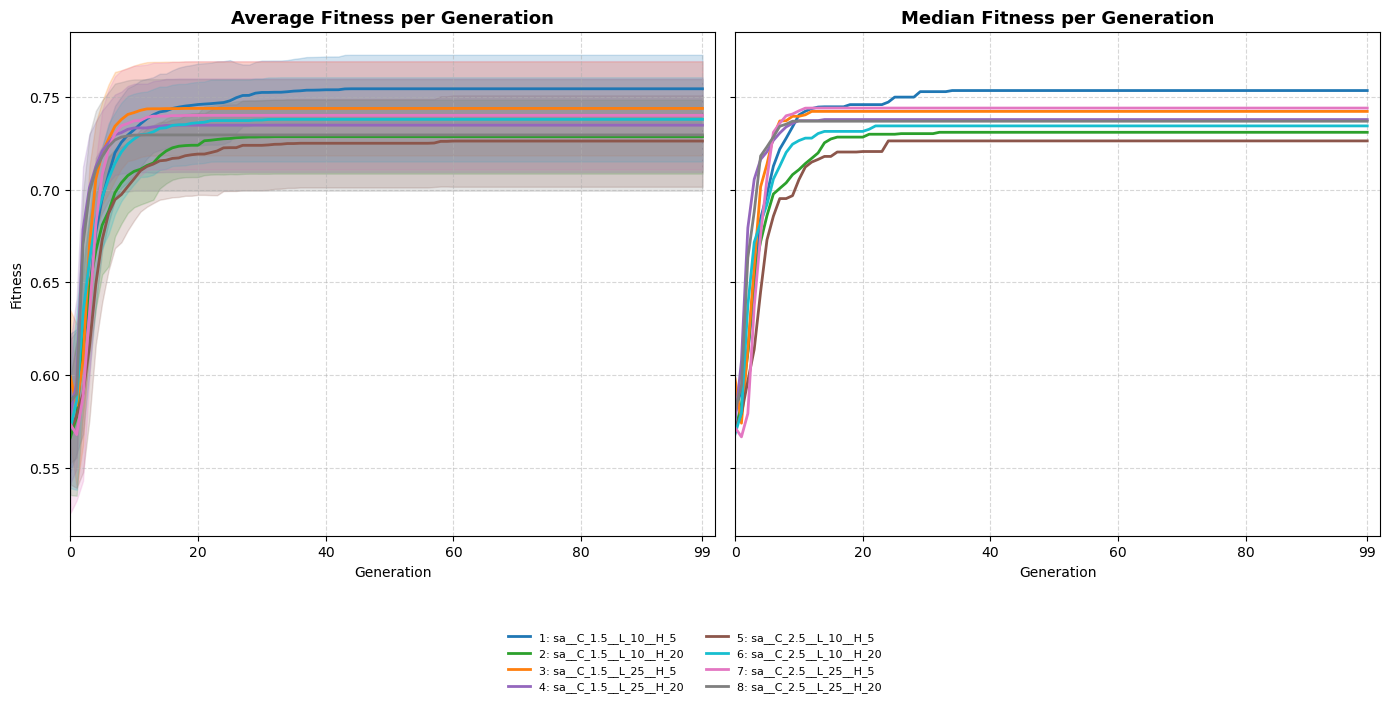

In [43]:
plot_avg_median_fit_per_generation(fitness_dfs_sa)

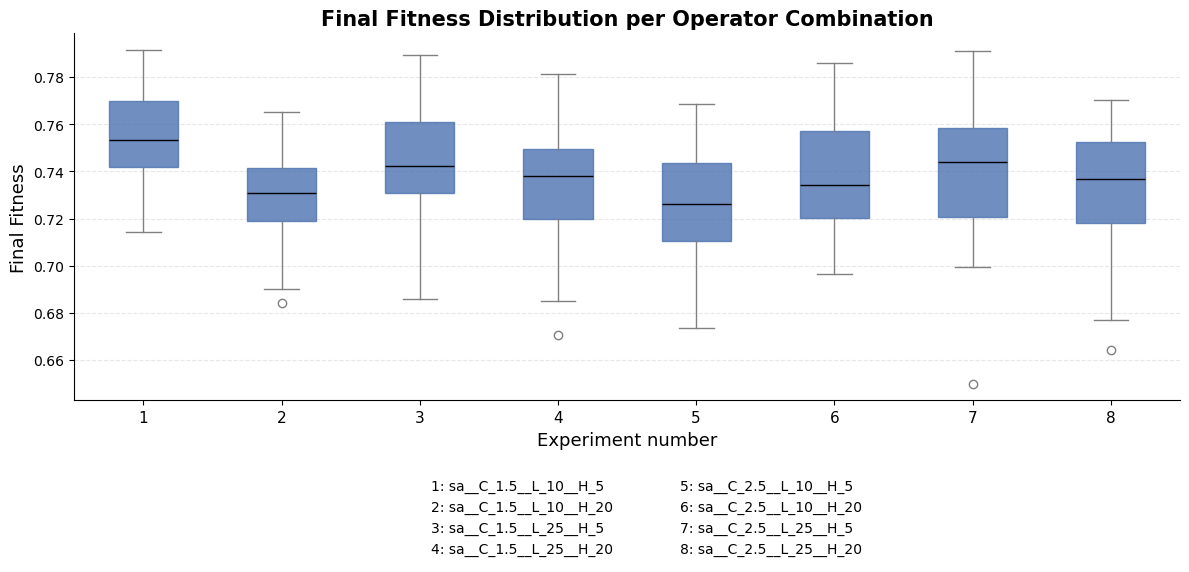

In [44]:
boxplots_final_fitness(fitness_dfs_sa)

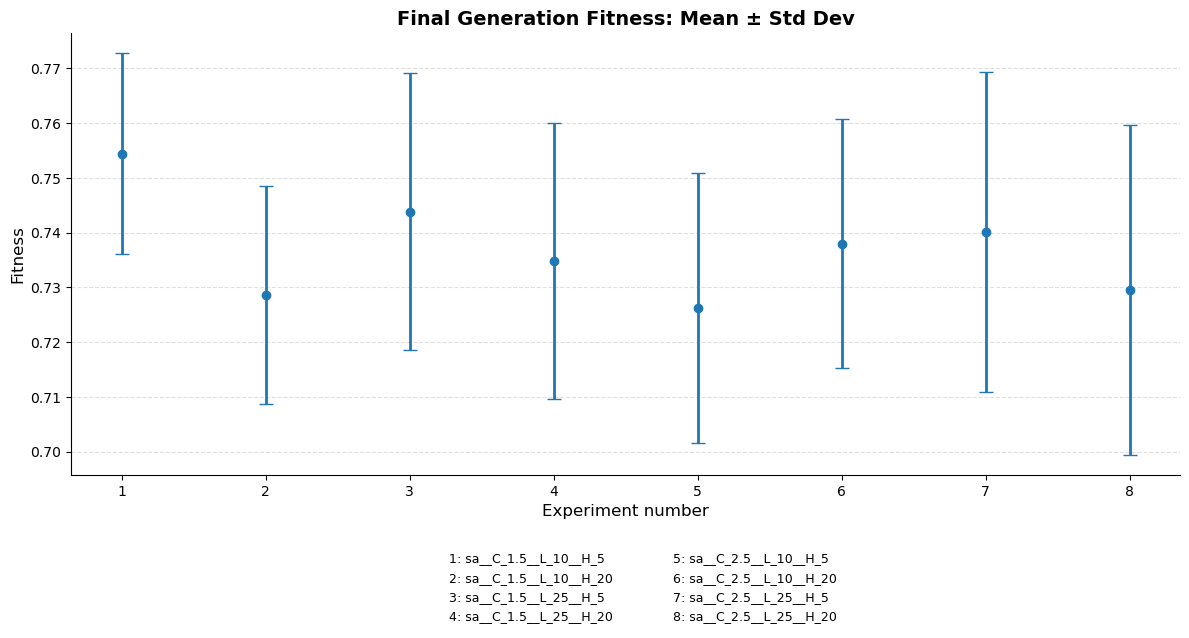

In [45]:
plot_mean_std_error(fitness_dfs_sa)

In [46]:
avg_elapsed_time_table(all_results_sa)

Experience Name  Elapsed Time Avg
1   sa__C_1.5__L_10__H_5          0.103063
2  sa__C_1.5__L_10__H_20          0.100648
3   sa__C_1.5__L_25__H_5          0.268725
4  sa__C_1.5__L_25__H_20          0.235571
5   sa__C_2.5__L_10__H_5          0.108239
6  sa__C_2.5__L_10__H_20          0.100921
7   sa__C_2.5__L_25__H_5          0.256116
8  sa__C_2.5__L_25__H_20          0.227385

In [47]:
compute_wilcoxon_pvalues(fitness_dfs_sa)

sa__C_1.5__L_10__H_5  sa__C_1.5__L_10__H_20  \
sa__C_1.5__L_10__H_5                    NaN                  0.000   
sa__C_1.5__L_10__H_20                 0.000                    NaN   
sa__C_1.5__L_25__H_5                  0.084                  0.047   
sa__C_1.5__L_25__H_20                 0.002                  0.289   
sa__C_2.5__L_10__H_5                  0.000                  0.641   
sa__C_2.5__L_10__H_20                 0.003                  0.140   
sa__C_2.5__L_25__H_5                  0.019                  0.119   
sa__C_2.5__L_25__H_20                 0.000                  0.516   

                       sa__C_1.5__L_25__H_5  sa__C_1.5__L_25__H_20  \
sa__C_1.5__L_10__H_5                  0.084                  0.002   
sa__C_1.5__L_10__H_20                 0.047                  0.289   
sa__C_1.5__L_25__H_5                    NaN                  0.158   
sa__C_1.5__L_25__H_20                 0.158                    NaN   
sa__C_2.5__L_10__H_5                  0.026                  0.114   
sa__C_2.5__L_10__H_20                 0.271                  0.824   
sa__C_2.5__L_25__H_5                  0.715                  0.146   
sa__C_2.5__L_25__H_20                 0.036                  0.584   

                       sa__C_2.5__L_10__H_5  sa__C_2.5__L_10__H_20  \
sa__C_1.5__L_10__H_5                  0.000                  0.003   
sa__C_1.5__L_10__H_20                 0.641                  0.140   
sa__C_1.5__L_25__H_5                  0.026                  0.271   
sa__C_1.5__L_25__H_20                 0.114                  0.824   
sa__C_2.5__L_10__H_5                    NaN                  0.100   
sa__C_2.5__L_10__H_20                 0.100                    NaN   
sa__C_2.5__L_25__H_5                  0.043                  0.584   
sa__C_2.5__L_25__H_20                 0.700                  0.371   

                       sa__C_2.5__L_25__H_5  sa__C_2.5__L_25__H_20  
sa__C_1.5__L_10__H_5                  0.019                  0.000  
sa__C_1.5__L_10__H_20                 0.119                  0.516  
sa__C_1.5__L_25__H_5                  0.715                  0.036  
sa__C_1.5__L_25__H_20                 0.146                  0.584  
sa__C_2.5__L_10__H_5                  0.043                  0.700  
sa__C_2.5__L_10__H_20                 0.584                  0.371  
sa__C_2.5__L_25__H_5                    NaN                  0.135  
sa__C_2.5__L_25__H_20                 0.135                    NaN

# 5. Compare GA, SA and HC - TEMOS DE ALTERAR PARA AS MELHORES SOLUÇÕES


In [48]:
results_ga_sa_hc={}
# Wrap Series into single-column DataFrames
results_ga_sa_hc['BEST_SA'] = pd.DataFrame({
    "Fitness_max": fitness_dfs_sa['sa__C_1.5__L_10__H_5_df.csv'].iloc[:, -1]
})

results_ga_sa_hc['BEST_GA'] = pd.DataFrame({
    "Fitness_max": fitness_dfs['inversion_mutation0.25__partially_matched_crossover0.9__el_True_df.csv'].iloc[:, -1]
})

# This one is already a DataFrame
results_ga_sa_hc['BEST_HC'] = result_hc['df']

KeyError: 'sa__C_1.5__L_10__H_5_df.csv'

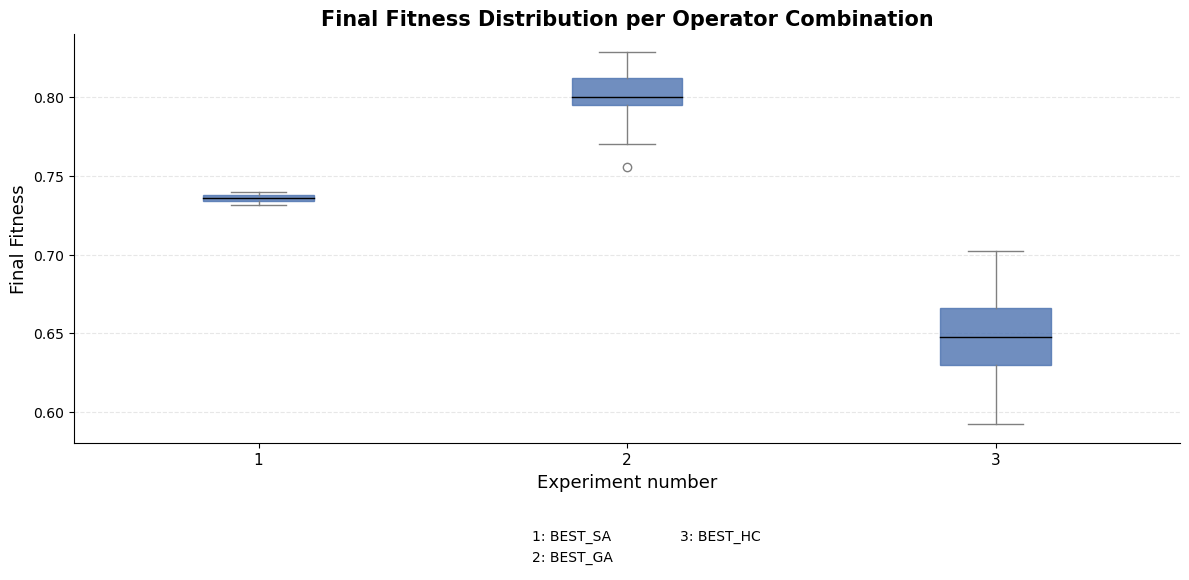

In [ ]:
boxplots_final_fitness(results_ga_sa_hc)

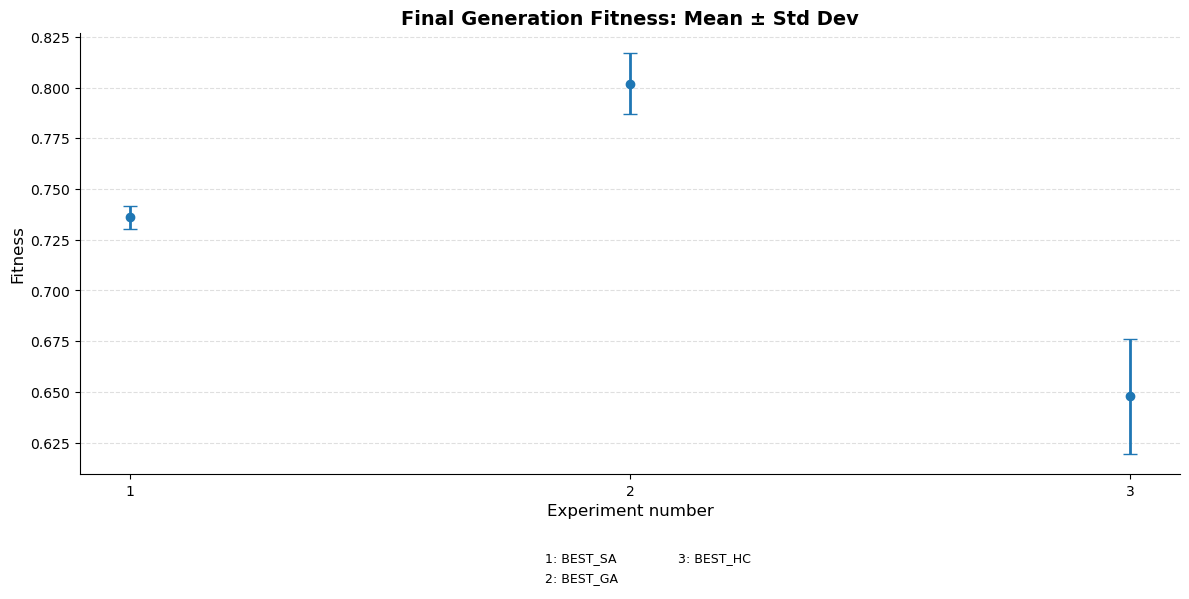

In [ ]:
plot_mean_std_error(results_ga_sa_hc)

In [ ]:
# compute_wilcoxon_pvalues(results_ga_sa_hc)

ValueError: The samples x and y must have the same length.

# Code to load all the csvs that will be generated

In [49]:
# Initialize dictionaries
fitness_dfs_sa = {}
results_hc = {}
fitness_dfs = {}

# Path to folder with CSVs (use "." for current directory)
folder_path = "./results"  # or specify: "./results" etc.

# Loop through files
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)
        key = filename[:-4]  # Remove ".csv"

        # Determine category by prefix
        if filename.startswith("sa"):
            fitness_dfs_sa[key] = df
        elif filename.startswith("hc"):
            results_hc[key] = df
        else:
            fitness_dfs[key] = df

In [50]:
fitness_dfs

{'swap_stages_slots_mutation0.6__partially_matched_crossover0.9__el_True_df':            0         1         2         3         4         5         6  \
 0   0.682891  0.682891  0.682891  0.725959  0.725959  0.727261  0.737690   
 1   0.668846  0.730543  0.730543  0.730543  0.766783  0.766783  0.788143   
 2   0.692757  0.699823  0.704912  0.717744  0.720877  0.733091  0.745965   
 3   0.691208  0.692961  0.724679  0.740240  0.751763  0.751763  0.757120   
 4   0.678438  0.689880  0.718471  0.733885  0.733885  0.761579  0.761579   
 5   0.691260  0.729695  0.750449  0.750449  0.763895  0.763895  0.770337   
 6   0.684443  0.684443  0.696648  0.703985  0.703985  0.717891  0.733491   
 7   0.710175  0.710175  0.712159  0.722080  0.734154  0.740674  0.745379   
 8   0.706157  0.706157  0.710697  0.746219  0.746219  0.758107  0.770671   
 9   0.685822  0.689632  0.730210  0.730210  0.730210  0.737806  0.737806   
 10  0.713395  0.713395  0.715868  0.715868  0.730347  0.730347  0.746070   

In [51]:
fitness_dfs_sa

{'sa__C_2.5__L_10__H_20_df':            0         1         2         3         4         5         6  \
 0   0.554125  0.593457  0.632764  0.644218  0.710279  0.750789  0.750789   
 1   0.561552  0.533143  0.688607  0.697743  0.700453  0.700453  0.725218   
 2   0.542861  0.538409  0.635378  0.660208  0.664629  0.664629  0.666255   
 3   0.569638  0.670220  0.669333  0.695101  0.725303  0.725303  0.727003   
 4   0.544403  0.680643  0.702442  0.757241  0.757241  0.770428  0.782283   
 5   0.547681  0.536564  0.562876  0.600456  0.666527  0.675431  0.686128   
 6   0.585341  0.558031  0.548205  0.628289  0.704883  0.720701  0.735294   
 7   0.601843  0.551370  0.594522  0.677289  0.687693  0.701218  0.733445   
 8   0.540858  0.582373  0.611031  0.647951  0.663251  0.677581  0.680382   
 9   0.621968  0.645600  0.664025  0.701419  0.701419  0.714074  0.721842   
 10  0.559954  0.577177  0.638435  0.684388  0.684388  0.684388  0.685743   
 11  0.584645  0.641415  0.679470  0.679470  0.6